In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv

# path of data
pie_path = r'D:\University\NUS\EE5907\PIE'
self_path = r'D:\University\NUS\EE5907\self'

random_seed = 1143583
np.random.seed(1143583)

# chose 25 subjects
chosen = np.random.default_rng(random_seed).choice(np.arange(1, 68 + 1), 25, replace=False)

images = []
labels = []

directory = Path(pie_path)
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)
    
    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(random_seed).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)

In [4]:
def flatten_image(image_path):
    image = plt.imread(image_path)
    # If the image is color, convert it to grayscale
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    return image.flatten()

# Create a list to store flattened images
flattened_images = [flatten_image(image_path) for image_path in all_images_paths]

X = np.array(flattened_images)

# mark PIE=0, and self=1
y = np.array([0] * 500 + [1] * 10)

# mean
mean_vector = np.mean(X, axis=0)
accuracy_self = 0

# Calculate the intra-class scatter matrix Sw and the inter-class scatter matrix Sb
S_W = np.zeros((X.shape[1], X.shape[1]))
S_B = np.zeros((X.shape[1], X.shape[1]))

for c in np.unique(y):
    class_scatter = np.cov(X[y==c].T)
    S_W += class_scatter

    mean_vector_c = np.mean(X[y==c], axis=0)
    mean_vector = mean_vector.reshape((mean_vector.shape[0], 1))
    mean_vector_c = mean_vector_c.reshape((mean_vector_c.shape[0], 1))
    S_B += len(X[y==c]) * (mean_vector_c - mean_vector).dot((mean_vector_c - mean_vector).T)

# 
eigenvalues, eigenvectors = eigh(np.linalg.inv(S_W).dot(S_B), eigvals=(0, 8)) 

projection_matrix = eigenvectors[:, ::-1]

X_lda = X.dot(projection_matrix)

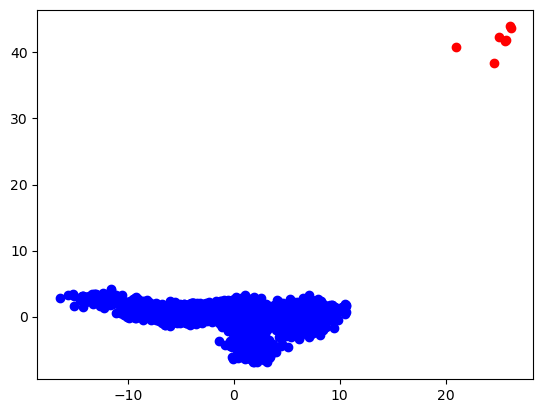

In [5]:
# 2D plot
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_lda[y_train == 69][:, 0],X_lda[y_train == 69][:, 1], label='self',c='r')
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_lda[y_train == i][:, 0],X_lda[y_train == i][:, 1],label='PIE',c='b')

plt.show()

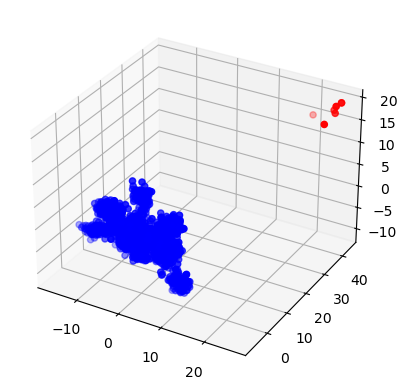

In [6]:
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X_lda[y_train == 69][:, 0],X_lda[y_train == 69][:, 1],X_lda[y_train == 69][:, 2],label=69,c="r",)
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_lda[y_train == i][:, 0],X_lda[y_train == i][:, 1],X_lda[y_train == i][:, 2],c = 'b')

plt.show()

In [7]:
X_lda_test = images_test @ eigvecs[:, :9]
self_X_lda_test = own_images_test @ eigvecs[:, :9]

def NN_classification(dim, X, y):
    dist_arr_test = LA.norm(X[:, :dim][:, np.newaxis] - X_lda[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  

    k = 2  
    knn_indices = dist_arr_test[:, :k]
    knn_labels = y_train[knn_indices]

    result = knn_labels[:, 0]
    acc = np.sum(result == y) / y.size

    return acc

def Accuracy(X, y):
    for i in [2, 3, 9]:
        print(f"Accuracy for {i}D = {NN_classification(i, X, y):.2%}")

print("For PIE:")
Accuracy(X_lda_test, labels_test)
print("For self:")
Accuracy(own_X_lda_test, own_labels_test)

For PIE:
Accuracy for 2D = 31.22%
Accuracy for 3D = 53.02%
Accuracy for 9D = 91.92%
For self:
Accuracy for 2D = 66.67%
Accuracy for 3D = 66.67%
Accuracy for 9D = 66.67%
